## Install Packages

We install:
- Audio processing: `librosa`, `mutagen`
- Plots: `Plotly`, `matplotlib`

In [52]:
!pip install pandas
!pip install librosa
!pip install plotly
!pip install matplotlib
!pip install mutagen
!pip install pillow

In [53]:
import os
import mutagen
import mutagen.wave
import numpy as np
import pandas as pd
import librosa.display
import IPython.display
import matplotlib.pyplot as plt

## Data Analysis

In [54]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

def compute_audio_statistics(dataset_df):
    metadata_dict = {'length': [], 'bitrate': [], 'channels': [], 'sample_rate': [], 'bits_per_sample': []}
    # Extract metadata
    for filepath in dataset_df['filepath']:
        metadata = get_audio_metadata_mutagen(filepath)
        for key in metadata_dict.keys():
            metadata_dict[key].append(metadata[key])
    # Add new columns to dataframe
    for key in metadata_dict.keys():
        dataset_df[key] = metadata_dict[key]

    return dataset_df

def get_audio_metadata_mutagen(filepath):
    metadata = {}
    f = mutagen.wave.WAVE(filepath)
    metadata['length'] = f.info.length
    metadata['bitrate'] = f.info.bitrate
    metadata['channels'] = f.info.channels
    metadata['sample_rate'] = f.info.sample_rate
    metadata['bits_per_sample'] = f.info.bits_per_sample
    return metadata

In [55]:
dataset_df = create_dataset_df('UrbanSound8K/metadata/UrbanSound8K.csv')
dataset_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,UrbanSound8K/audio\fold5\100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,UrbanSound8K/audio\fold5\100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,UrbanSound8K/audio\fold5\100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,UrbanSound8K/audio\fold5\100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,UrbanSound8K/audio\fold5\100263-2-0-137.wav


dataset_df.groupby('class').slice_file_name.count()

We can observe all the classes except `car_horn`, `gun_shot` and `siren` have 1000 samples.

In [56]:
dataset_df = dataset_df.drop(columns=['fold', 'slice_file_name', 'fsID', 'start', 'end'])
audio_statistics_df = compute_audio_statistics(dataset_df)

We can observe in the following tables that the data has been recorded and digitalized in different ways.

- It has been mostly recorded using 2 channels in almost all the samples (stereo).
- The sample rates go from 8kHz to 192kHz (mostly 44kHz, 48Khz)
- The length of the audios goes from 0.0008s to 4s (mostly 4s)
- The bits per sample used go from 4 to 32 (mostly 16 bits)

The data will need to be standardized before to be fed to a machine learning model.

In [57]:
audio_statistics_df.describe()

,salience,classID,length,bitrate,channels,sample_rate,bits_per_sample
count,8732.000000,8732.000000,8732.000000,8.732000e+03,8732.000000,8732.000000,8732.000000
mean,1.347000,4.592877,3.603644,4.495311e+05,1.915369,48456.979272,18.780119
std,0.476043,2.894544,0.980913,5.480813e+05,0.278348,15300.080707,4.227168
min,1.000000,0.000000,0.000816,1.102500e+04,1.000000,8000.000000,4.000000
25%,1.000000,2.000000,4.000000,3.528000e+05,2.000000,44100.000000,16.000000
50%,1.000000,4.000000,4.000000,3.528000e+05,2.000000,44100.000000,16.000000
75%,2.000000,7.000000,4.000000,5.292000e+05,2.000000,48000.000000,24.000000
max,2.000000,9.000000,4.000000,4.515840e+07,2.000000,192000.000000,32.000000


In [66]:
audio_statistics_df['sample_rate'].value_counts(),\
audio_statistics_df['bits_per_sample'].value_counts(),\
audio_statistics_df['length'].value_counts(),

(44100     5370
 48000     2502
 96000      610
 24000       82
 16000       45
 22050       44
 11025       39
 192000      17
 8000        12
 11024        7
 32000        4
 Name: sample_rate, dtype: int64,
 16    5758
 24    2753
 32     169
 8       43
 4        9
 Name: bits_per_sample, dtype: int64,
 4.000000    7325
 1.440000      10
 1.330000      10
 1.090000       9
 1.020000       7
             ... 
 1.085397       1
 1.039546       1
 2.088503       1
 3.220000       1
 3.505986       1
 Name: length, Length: 973, dtype: int64)

If we now look at the audio statistics per class we see that:

- The length of the audios for the classes 1 and 6 are much smaller than for the rest of classes.
- The rest of metadata is very similar for every class, can't see any trend.

In [59]:
audio_statistics_df.groupby('class').describe()

salience                                               \
                    count      mean       std  min  25%  50%  75%  max   
class                                                                    
air_conditioner    1000.0  1.431000  0.495464  1.0  1.0  1.0  2.0  2.0   
car_horn            429.0  1.643357  0.479567  1.0  1.0  2.0  2.0  2.0   
children_playing   1000.0  1.412000  0.492441  1.0  1.0  1.0  2.0  2.0   
dog_bark           1000.0  1.355000  0.478753  1.0  1.0  1.0  2.0  2.0   
drilling           1000.0  1.098000  0.297463  1.0  1.0  1.0  1.0  2.0   
engine_idling      1000.0  1.084000  0.277527  1.0  1.0  1.0  1.0  2.0   
gun_shot            374.0  1.187166  0.390567  1.0  1.0  1.0  1.0  2.0   
jackhammer         1000.0  1.269000  0.443662  1.0  1.0  1.0  2.0  2.0   
siren               929.0  1.710441  0.453802  1.0  1.0  2.0  2.0  2.0   
street_music       1000.0  1.375000  0.484365  1.0  1.0  1.0  2.0  2.0   

                 classID       ... sample_rate           bits_per_sample  \
                   count mean  ...         75%       max           count   
class                          ...                                         
air_conditioner   1000.0  0.0  ...     48000.0   48000.0          1000.0   
car_horn           429.0  1.0  ...     48000.0   96000.0           429.0   
children_playing  1000.0  2.0  ...     48000.0   96000.0          1000.0   
dog_bark          1000.0  3.0  ...     48000.0   96000.0          1000.0   
drilling          1000.0  4.0  ...     44100.0  192000.0          1000.0   
engine_idling     1000.0  5.0  ...     48000.0   96000.0          1000.0   
gun_shot           374.0  6.0  ...     48000.0   96000.0           374.0   
jackhammer        1000.0  7.0  ...     48000.0   96000.0          1000.0   
siren              929.0  8.0  ...     48000.0   48000.0           929.0   
street_music      1000.0  9.0  ...     44100.0   96000.0          1000.0   

                                                                     
                       mean       std   min   25%   50%   75%   max  
class                                                                
air_conditioner   19.584000  4.393432  16.0  16.0  16.0  24.0  32.0  
car_horn          17.641026  3.280044  16.0  16.0  16.0  16.0  32.0  
children_playing  18.964000  4.077171   4.0  16.0  16.0  24.0  24.0  
dog_bark          18.288000  3.939108  16.0  16.0  16.0  24.0  32.0  
drilling          18.180000  4.235273   4.0  16.0  16.0  24.0  32.0  
engine_idling     19.688000  4.459882  16.0  16.0  16.0  24.0  32.0  
gun_shot          18.331551  3.640290  16.0  16.0  16.0  24.0  24.0  
jackhammer        20.044000  5.047727   4.0  16.0  16.0  24.0  32.0  
siren             17.550054  3.630558   8.0  16.0  16.0  16.0  32.0  
street_music      18.512000  3.714789  16.0  16.0  16.0  24.0  24.0  

[10 rows x 56 columns]

## Data Visualization
As the data consists of Audio files we will use the `Librosa` library to load, plot and perform audio processing.

We will use the `IPython.display.Audio` package to listen the files directly in the Jupyter Notebook.

In [60]:
# Randomly select one sample of each class
random_samples = dataset_df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

In [61]:
# Listen to the recordings (index can be changed to listen to a different recording)
index = 1
print('Listen to {} sample'.format(labels[index]))
IPython.display.Audio(audio_samples[index])

Listen to car_horn sample


### Waveform

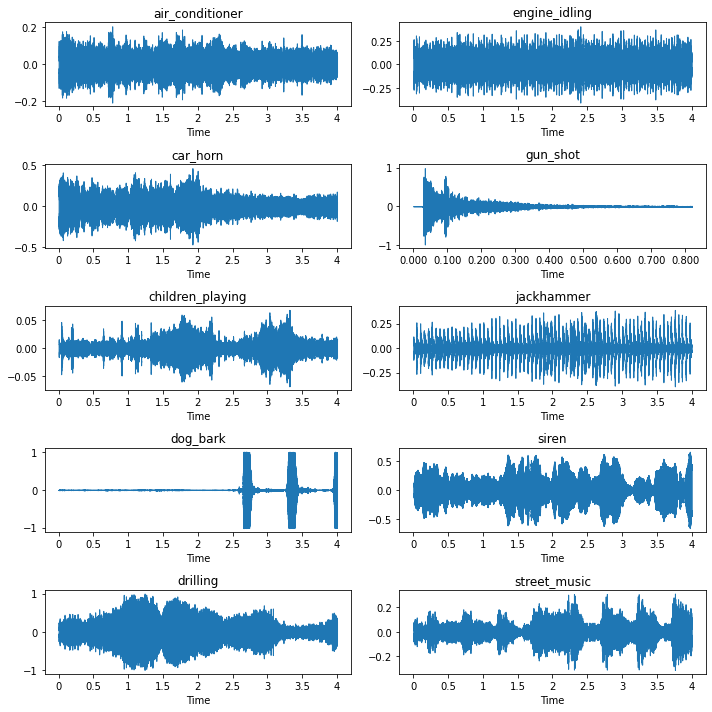

In [62]:
# Visualize the waveforms
fig, axs = plt.subplots(5, 2, figsize=(10,10))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        librosa.display.waveshow(audio_file, sr=sample_rate, ax=axs[row][col])
        axs[row][col].set_title(f'{labels[index]}')
        index += 1
fig.tight_layout()

### STFT

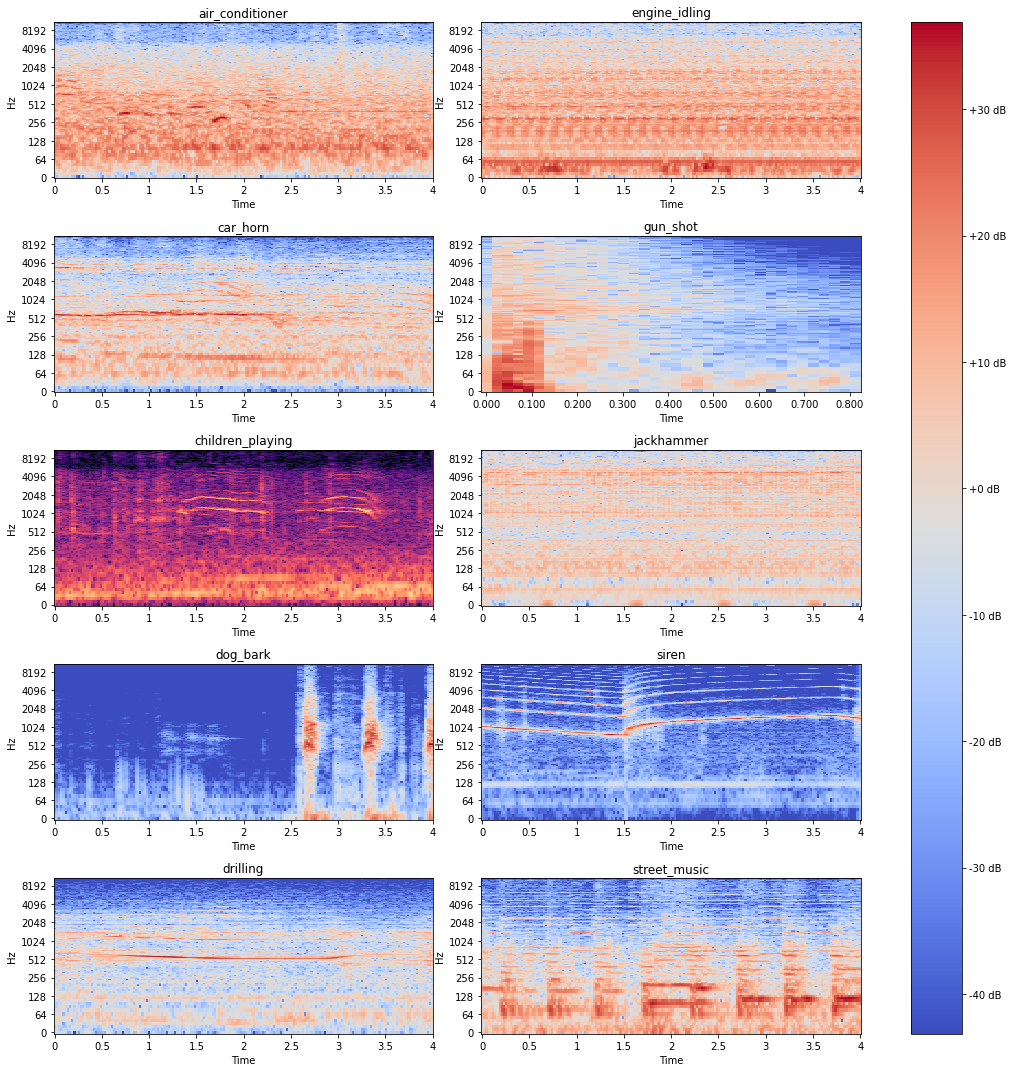

In [63]:
# Visualize the STFT
n_fft = 2048
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(15,15))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        stft = librosa.stft(audio_file, n_fft=n_fft, hop_length=hop_length)
        mag_db = librosa.amplitude_to_db(np.abs(stft))
        spec = librosa.display.specshow(mag_db,
                             sr=sample_rate,
                             hop_length=hop_length,
                             x_axis="time",
                             y_axis='log',
                             ax=axs[row][col])
        axs[row][col].set_title(f'{labels[index]}')
        index += 1
fig.tight_layout()
fig.colorbar(spec, ax=axs, format="%+2.f dB")

### Mel-Spectogram
The frequency magnitude is transformed so, that takes into account how humans perceive and process audio signals.

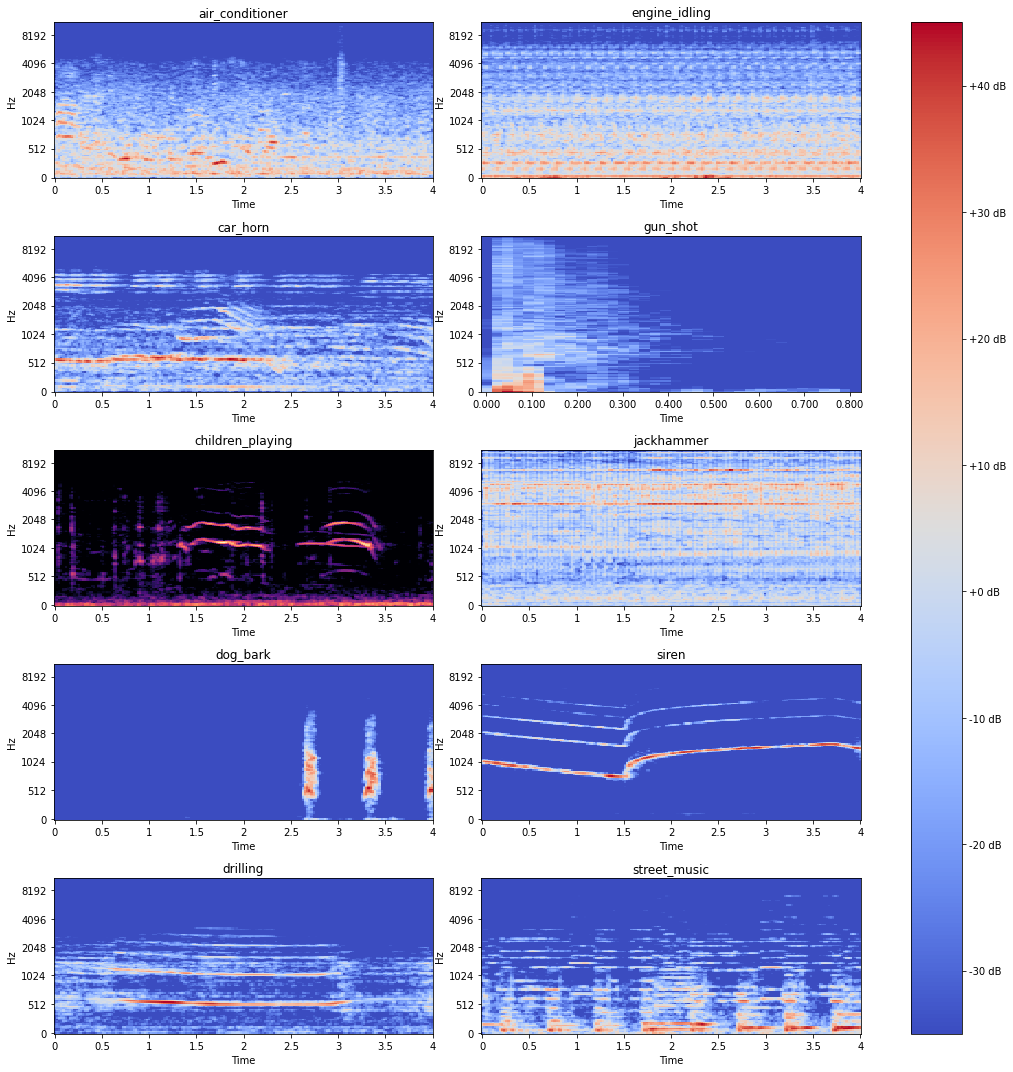

In [64]:
# Visualize the Mel-Spectograms
n_fft = 2048
hop_length = 512
n_mels = 128
fig, axs = plt.subplots(5, 2, figsize=(15,15))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        mel = librosa.feature.melspectrogram(y=audio_file,
                                             sr=sample_rate,
                                             n_fft=n_fft,
                                             hop_length=hop_length,
                                             n_mels=n_mels)
        mag_db = librosa.amplitude_to_db(np.abs(mel))
        spec = librosa.display.specshow(mag_db,
                                        sr=sample_rate,
                                        hop_length=hop_length,
                                        x_axis="time",
                                        y_axis='mel',
                                        ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()
fig.colorbar(spec, ax=axs, format="%+2.f dB")

### MFCC

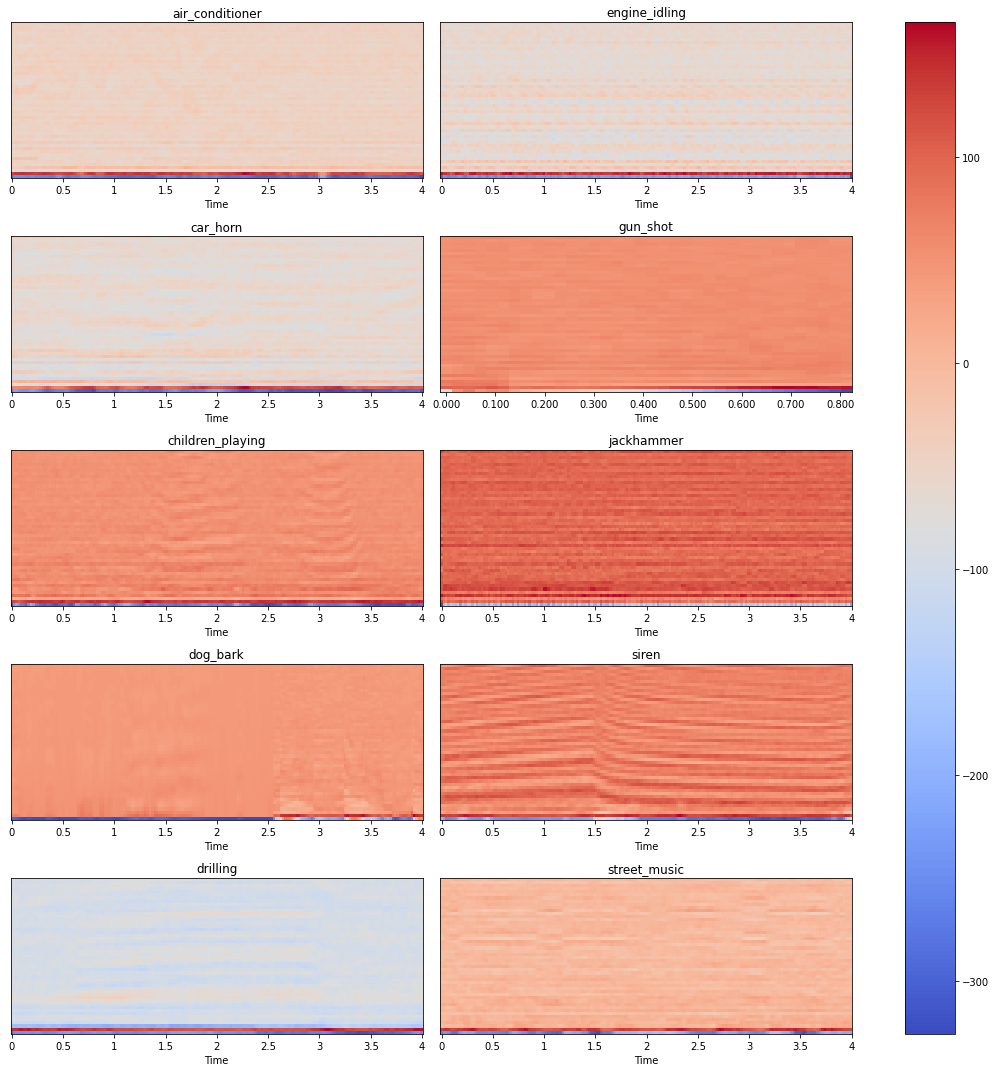

In [65]:
# Visualize the MFCC
n_fft = 2048
hop_length = 512
n_mfcc = 50
fig, axs = plt.subplots(5, 2, figsize=(15,15))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        mfccs = librosa.feature.mfcc(y=audio_file,
                                     sr=sample_rate,
                                     n_fft=n_fft,
                                     hop_length=hop_length,
                                     n_mfcc=n_mfcc)
        spec = librosa.display.specshow(mfccs,
                                        sr=sample_rate,
                                        hop_length=hop_length,
                                        x_axis="time",
                                        ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()
fig.colorbar(spec, ax=axs)

After taking a look at the graphs for some different permutations, we can observe that the signals are different enough to be classified correctly.